# <center>Example Dashboard of Probabilistic Model</center>

In [14]:
import gzip
import pickle

import pandas as pd
import numpy as np
import plotly.express as px

import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox, interactive_output
import ipysheet


filename = './data/slider_values.pkl.gz'

with gzip.open(filename, 'rb') as f:
    X_df = pickle.load(f)
    
filename = './data/outcomes.pkl.gz'

with gzip.open(filename, 'rb') as f:
    Y_df = pickle.load(f)
    
filename = './data/prob_coef.pkl.gz'

with gzip.open(filename, 'rb') as f:
    coef_dict = pickle.load(f)

In [27]:
knowledge_dict = {
    'init':X_df.loc['knowledge', 2019],
    'max':X_df.loc['knowledge', :].max(),
    'min':X_df.loc['knowledge', :].min(),
}

punctuality_dict = {
    'init':X_df.loc['punctuality', 2019],
    'max':X_df.loc['punctuality', :].max(),
    'min':X_df.loc['punctuality', :].min(),
}

relevance_dict = {
    'init':X_df.loc['relevance', 2019],
    'max':X_df.loc['relevance', :].max(),
    'min':X_df.loc['relevance', :].min(),
}

value_dict = {
    'init':X_df.loc['value', 2019],
    'max':X_df.loc['value', :].max(),
    'min':X_df.loc['value', :].min(),
}


knowledge = widgets.FloatSlider(
    value=knowledge_dict['init'],
    min=knowledge_dict['min'] - 0.1,
    max=knowledge_dict['max'] + 0.2,
    step=0.01,
    description='knowledge',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

punctuality = widgets.FloatSlider(
    value=punctuality_dict['init'],
    min=punctuality_dict['min'] - 0.1,
    max=punctuality_dict['max'] + 0.2,
    step=0.01,
    description='punctuality',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

relevance = widgets.FloatSlider(
    value=relevance_dict['init'],
    min=relevance_dict['min'] - 0.1,
    max=relevance_dict['max'] + 0.2,
    step=0.01,
    description='relevance',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

value = widgets.FloatSlider(
    value=value_dict['init'],
    min=value_dict['min'] - 0.1,
    max=value_dict['max'] + 0.2,
    step=0.01,
    description='value',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

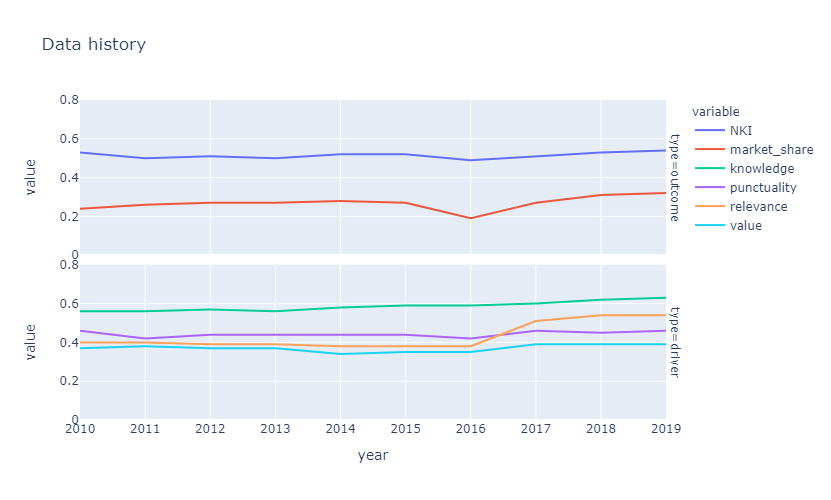

In [28]:
from ipywidgets import interact, HBox, VBox, interactive_output
import pandas as pd
import plotly.express as px

y_df = Y_df.loc[['Nöjd Kund Index (NKI) allmänheten', 'Kollektivtrafikens marknadsandel'],:]
y_df.index = ['NKI', 'market_share']

data_df = pd.concat([X_df, y_df], axis=0).unstack().reset_index()
data_df.columns = ['year', 'variable', 'value']
data_df['type'] = (['driver']*4 + ['outcome']*2 )*10
data_df['value'] = data_df['value'].apply(lambda x:round(x, 2))

fig = px.line(data_df, x='year', y='value', color='variable',
              width=800, height=500, range_y = [0, 0.8], facet_row='type',
              category_orders={'variable':['NKI', 'market_share', 'knowledge', 'punctuality', 'relevance', 'value'],
                              'type':['outcome', 'driver']},
              title='Data history')

fig.update_layout(xaxis = {'nticks':10})
fig.show()

---

In [29]:
from ipywidgets import interact, HBox, VBox, interactive_output
import pandas as pd
import plotly.figure_factory as ff
import plotly.express as px

def compute_num(knowledge, punctuality, relevance, value):
    X = np.array([
    knowledge,
    punctuality,
    relevance,
    value
    ])
    
    samples_NKI = coef_dict['bias_NKI'] + coef_dict['coef_NKI'] @ X
    samples_share = coef_dict['bias_share'] + coef_dict['coef_share'] @ X
        
    df = pd.DataFrame({'estimated_values':list(samples_NKI) + list(samples_share),
                      'outcomes':['NKI']*len(samples_NKI) + ['market_share']*len(samples_share)})
    return df

def plot(knowledge, punctuality, relevance, value):
    df = compute_num(knowledge, punctuality, relevance, value)
    fig = px.histogram(df, x='estimated_values', nbins=200, color='outcomes',
                       marginal='box', # or violin, rug
                       histnorm='probability',
                       width = 600,
                      )
    return fig.show()

def table(knowledge, punctuality, relevance, value):
    sheet_df = compute_num(knowledge, punctuality, relevance, value)
    sheet_df = sheet_df.groupby('outcomes').agg([('lower', lambda x: x.quantile(.05)),
                                                 'median',
                                                 ('upper', lambda x: x.quantile(.95)), 
                                                 ])
    sheet_df.columns = [f'{b}' for a,b in sheet_df.columns]
    sheet_df = sheet_df.reset_index()
    sheet = ipysheet.from_dataframe(sheet_df)    
    return display(sheet)

out_table = widgets.interactive_output(table, 
                                 {'knowledge': knowledge, 'punctuality': punctuality, 'relevance': relevance, 'value':value})

out_plot = widgets.interactive_output(plot, 
                                 {'knowledge': knowledge, 'punctuality': punctuality, 'relevance': relevance, 'value':value})

layout = widgets.Layout(display='flex',
                flex_flow='raw',
                align_items='center',
                width='100%')
display(HBox([VBox([knowledge, punctuality, relevance, value]), 
              VBox([out_table, out_plot])], layout=layout))